In [1]:
!pip install transformers

In [2]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

In [3]:
model = AutoModelForSequenceClassification.from_pretrained("klue/roberta-base")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'clas

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(24)
np.random.seed(24)
torch.manual_seed(24)
model.to(device) 
learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-5)

In [5]:
def encode_data(tokenizer, candi_seconds, candi_firsts, max_length):
    
    input_ids = []
    attention_masks = []

    for candi_second, candi_first in zip(candi_seconds, candi_firsts):
        encoded_data = tokenizer.encode_plus(candi_second, candi_first, 
                                             max_length=max_length, 
                                             pad_to_max_length=True, 
                                             truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train_data_df = pd.read_csv("/content/drive/MyDrive/Final project/인과관계_추론/SKT_COPA_Train.tsv", delimiter='\t')
dev_data_df = pd.read_csv("/content/drive/MyDrive/Final project/인과관계_추론/SKT_COPA_Dev.tsv", delimiter='\t')

train_data_df.columns = ["ID", "sentence", "question", "candi_first", "candi_second", "answer"]
dev_data_df.columns = ["ID", "sentence", "question", "candi_first", "candi_second", "answer"]

train_data_df.head()

,ID,sentence,question,candi_first,candi_second,answer
0,1,이퀄라이저로 저음 음역대 소리 크기를 키웠다.,결과,베이스 소리가 잘 들리게 되었다.,베이스 소리가 들리지 않게 되었다.,1
1,2,음료에 초콜렛 시럽을 넣었다.,결과,음료수가 더 달아졌다.,음료수가 차가워졌다.,1
2,3,남자는 휴대폰을 호수에 빠뜨렸다.,결과,휴대폰이 업그레이드 되었다.,휴대폰이 고장났다.,2
3,4,옆 집 사람이 이사를 나갔다.,원인,옆 집 사람은 계약이 완료되었다.,옆 집 사람은 계약을 연장했다.,1
4,5,문을 밀었다.,결과,문이 잠겼다.,문이 열렸다.,2


In [8]:
print(len(train_data_df))
print(len(dev_data_df))

3080
500


In [9]:
train_data_df["answer"] = train_data_df["answer"].replace([1], 0)
train_data_df["answer"] = train_data_df["answer"].replace([2], 1)

dev_data_df["answer"] = dev_data_df["answer"].replace([1], 0)
dev_data_df["answer"] = dev_data_df["answer"].replace([2], 1)

In [10]:
import re

def make_cause(document):
    document = document.replace("원인", "왜냐면") # 문장을 이어주기 위해
    document = document.replace("결과", "그래서") # 문장을 이어주기 위해
    return document

def cleaning(document):
    document = re.sub(r"[^0-9a-zA-Zㄱ-ㅎ | 가-힣]+", "", document) # 한글, 영어, 숫자만 남김  
    return document

In [11]:
train_data_df["question"] = train_data_df["question"].apply(make_cause)
train_data_df["candi_first"] = train_data_df["question"] + " " + train_data_df["candi_first"]
train_data_df["candi_second"] = train_data_df["question"] + " " + train_data_df["candi_second"]
train_data_df["candi_first"] = train_data_df["sentence"] + " " + train_data_df["candi_first"]
train_data_df["candi_second"] = train_data_df["sentence"] + " " + train_data_df["candi_second"]


dev_data_df["question"] = dev_data_df["question"].apply(make_cause)
dev_data_df["candi_first"] = dev_data_df["question"] + " " + dev_data_df["candi_first"]
dev_data_df["candi_second"] = dev_data_df["question"] + " " + dev_data_df["candi_second"]
dev_data_df["candi_first"] = dev_data_df["sentence"] + " " + dev_data_df["candi_first"]
dev_data_df["candi_second"] = dev_data_df["sentence"] + " " + dev_data_df["candi_second"]


In [12]:
train_data_df = train_data_df.drop(["sentence", "question"], axis=1)
dev_data_df = dev_data_df.drop(["sentence", "question"], axis=1)

In [13]:
train_data_df

,ID,candi_first,candi_second,answer
0,1,이퀄라이저로 저음 음역대 소리 크기를 키웠다. 그래서 베이스 소리가 잘 들리게 되었다.,이퀄라이저로 저음 음역대 소리 크기를 키웠다. 그래서 베이스 소리가 들리지 않게 되었다.,0
1,2,음료에 초콜렛 시럽을 넣었다. 그래서 음료수가 더 달아졌다.,음료에 초콜렛 시럽을 넣었다. 그래서 음료수가 차가워졌다.,0
2,3,남자는 휴대폰을 호수에 빠뜨렸다. 그래서 휴대폰이 업그레이드 되었다.,남자는 휴대폰을 호수에 빠뜨렸다. 그래서 휴대폰이 고장났다.,1
3,4,옆 집 사람이 이사를 나갔다. 왜냐면 옆 집 사람은 계약이 완료되었다.,옆 집 사람이 이사를 나갔다. 왜냐면 옆 집 사람은 계약을 연장했다.,0
4,5,문을 밀었다. 그래서 문이 잠겼다.,문을 밀었다. 그래서 문이 열렸다.,1
...,...,...,...,...
3075,3076,계약직으로 일하던 남성은 퇴사했다. 왜냐면 계약을 연장했다.,계약직으로 일하던 남성은 퇴사했다. 왜냐면 계약이 종료되었다.,1
3076,3077,목이 마르다. 왜냐면 물을 마시지 못했다.,목이 마르다. 왜냐면 텀블러를 샀다.,0
3077,3078,노래를 오랫동안 불렀다. 그래서 목이 아프다.,노래를 오랫동안 불렀다. 그래서 노래방이 폐업했다.,0
3078,3079,사람들이 일제히 함성을 지른다. 왜냐면 우리나라 축구팀이 골을 넣었다.,사람들이 일제히 함성을 지른다. 왜냐면 우리나라 축구팀이 경기에서 패배했다.,1


In [14]:
candi_firsts_train = train_data_df.candi_first.values
candi_seconds_train = train_data_df.candi_second.values
answers_train = train_data_df.answer.values.astype(int)

candi_firsts_dev = dev_data_df.candi_first.values
candi_seconds_dev = dev_data_df.candi_second.values
answers_dev = dev_data_df.answer.values.astype(int)

In [15]:
# Encoding data
max_seq_length = 512
input_ids_train, attention_masks_train = encode_data(tokenizer, candi_seconds_train, candi_firsts_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, candi_seconds_dev, candi_firsts_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
# Building Dataloaders
batch_size = 8

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [17]:
epochs = 7
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):

  # Training
    epoch_train_loss = 0 # Cumulative loss
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)     

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()
      
        if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)          
    train_loss_values.append(epoch_train_loss)

    # Evaluation
    epoch_dev_accuracy = 0 # Cumulative accuracy
    model.eval()

    for batch in dev_dataloader:
    
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]
                
        with torch.no_grad():        
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                    
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
    
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
    
        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)

Epoch: 100%|██████████| 7/7 [21:55<00:00, 187.92s/it]


In [18]:
train_loss_values

[0.6968698525583589,
 0.6940919006025636,
 0.6253150709263691,
 0.403342001304611,
 0.23861945753723576,
 0.1393673797059417,
 0.08371571081663276]

In [19]:
dev_acc_values

[0.498015873015873,
 0.498015873015873,
 0.7242063492063492,
 0.8015873015873016,
 0.7599206349206349,
 0.8154761904761905,
 0.8095238095238095]

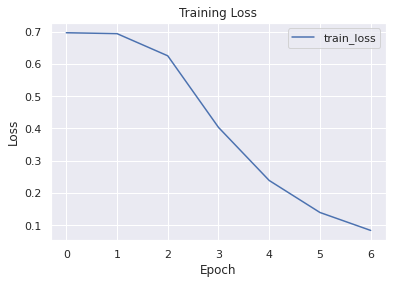

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

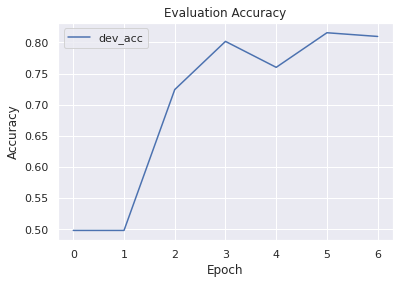

In [21]:
plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.show()